In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import os

# Chargement de la base Sentiment140 préprocessée 

In [2]:
STOP_WORDS = True
LEMMATIZATION = True
file = "train"
if STOP_WORDS:
    file += "_stop"
if LEMMATIZATION:
    file += "_lemm"
df = pd.read_pickle(os.path.join("data", "sentiment140", file+".bz2"))

In [3]:
df = df.sample(50000, random_state=1234)
df.sentiment = df.sentiment.apply(lambda x: 'Negative' if x == 0 else 'Positive')
df

,sentiment,id,date,query_string,user,text
1062048,Positive,1964017646,Fri May 29 13:35:57 PDT 2009,NO_QUERY,ashakur,@PcShakur I guess so. We should go make it a f...
1236895,Positive,1992914899,Mon Jun 01 09:31:47 PDT 2009,NO_QUERY,RabbiShaiSpecht,@PsychicSophie Thank you!
1237054,Positive,1992954642,Mon Jun 01 09:35:38 PDT 2009,NO_QUERY,RobinRene7,it's just another day here at the office...I a...
229979,Negative,1978627799,Sat May 30 23:57:09 PDT 2009,NO_QUERY,valfvergara,@triciasays i miss kickboxing
760772,Negative,2296927988,Tue Jun 23 09:48:35 PDT 2009,NO_QUERY,SarahAnnGreen,@AmandaFClark Thats rubbish!
...,...,...,...,...,...,...
46422,Negative,1677402582,Sat May 02 01:53:46 PDT 2009,NO_QUERY,kmac1984,wondering what the hell is gonna happen next??...
34170,Negative,1564728728,Mon Apr 20 04:42:44 PDT 2009,NO_QUERY,engers,@jkoxvold Me too
888464,Positive,1687307615,Sun May 03 08:20:39 PDT 2009,NO_QUERY,_Alectrona_,I'm off Will maybe tweet later...Bye!
292279,Negative,1995953530,Mon Jun 01 14:18:18 PDT 2009,NO_QUERY,TraceyyMartinn,stomach hurts and i desperatly want to go sho...


In [4]:
X = df.text.to_list()
y = df.sentiment.to_list()

# Count Vectorizer
## Exemple

In [5]:
arr = ["Car was cleaned by Jack", "Jack was cleaned by Car", "Hello"]
vectorizer = CountVectorizer()
X_ = vectorizer.fit_transform(arr)
vectorizer.get_feature_names()

['by', 'car', 'cleaned', 'hello', 'jack', 'was']

In [6]:
print(X_.toarray())

[[1 1 1 0 1 1]
 [1 1 1 0 1 1]
 [0 0 0 1 0 0]]


## Application

In [7]:
def conf_matrix(X, y, vectorizer, model, verbose=True):
    X = vectorizer.fit_transform(X).toarray()
    
    X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(X), y, train_size=0.80, random_state=1234)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    sc_accuracy = metrics.accuracy_score(y_pred, y_test)    
    sc_balanced_accuracy = metrics.balanced_accuracy_score(y_pred, y_test)
    sc_f1 = metrics.f1_score(y_pred, y_test, pos_label="Positive")
    sc_recall = metrics.recall_score(y_pred, y_test, pos_label="Positive")
    sc_precision = metrics.precision_score(y_pred, y_test, pos_label="Positive")
    sc_roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    probs = model.predict_proba(X_test)[:,1]
    
    if verbose:    
        metrics.plot_confusion_matrix(model, X_test, y_test)
        plt.show()

        print(f"Accuracy : {sc_accuracy}")
        print(f"Balanced accuracy : {sc_balanced_accuracy}")
    #     print(f"Recall : {sc_recall}")
    #     print(f"Precision : {sc_precision}")
    #     print(f"F1 : {sc_f1}")
        print(f"ROC AUC : {sc_roc_auc}")
    
    metrics_score = {'accuracy': sc_accuracy, 'balanced_accuracy': sc_balanced_accuracy, 'roc_auc': sc_roc_auc}
    
    if not verbose:
        return X_train, X_test, y_train, y_test, probs, metrics_score
    

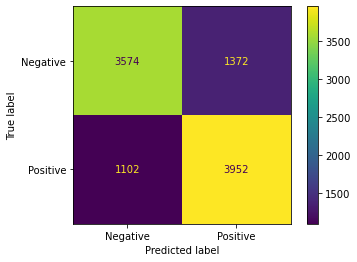

Accuracy : 0.7526
Balanced accuracy : 0.7533137545880655
ROC AUC : 0.8268280812273943


In [8]:
conf_matrix(X, y, CountVectorizer(max_features = 1000), LogisticRegression())

# TF-IDF
## Exemple

In [9]:
arr = ["Blue car was cleaned by Jack", "Jack was cleaned by red car", "Hello"]
vectorizer = TfidfVectorizer()
X_ = vectorizer.fit_transform(arr)
vectorizer.get_feature_names()

['blue', 'by', 'car', 'cleaned', 'hello', 'jack', 'red', 'was']

In [10]:
print(X_.toarray())

[[0.50689001 0.38550292 0.38550292 0.38550292 0.         0.38550292
  0.         0.38550292]
 [0.         0.38550292 0.38550292 0.38550292 0.         0.38550292
  0.50689001 0.38550292]
 [0.         0.         0.         0.         1.         0.
  0.         0.        ]]


## Application

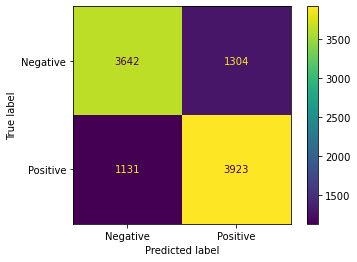

Accuracy : 0.7565
Balanced accuracy : 0.7567841131426452
ROC AUC : 0.8359262424369179


In [11]:
conf_matrix(X, y, TfidfVectorizer(max_features = 1000), LogisticRegression())

# N-grams
## Exemple

In [12]:
arr = ["Blue car was cleaned by Jack", "Jack was cleaned by red car", "Hello"]
vectorizer = CountVectorizer(ngram_range=(2,2))
X_ = vectorizer.fit_transform(arr)
vectorizer.get_feature_names()

['blue car',
 'by jack',
 'by red',
 'car was',
 'cleaned by',
 'jack was',
 'red car',
 'was cleaned']

In [13]:
print(X_.toarray())

[[1 1 0 1 1 0 0 1]
 [0 0 1 0 1 1 1 1]
 [0 0 0 0 0 0 0 0]]


## Application

C:\Users\pasqu\anaconda3\envs\data-2A\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


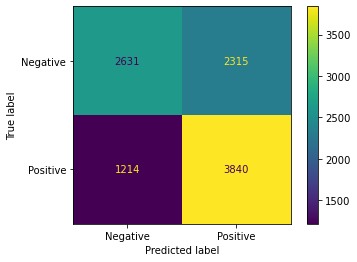

Accuracy : 0.6471
Balanced accuracy : 0.6540741507586314
ROC AUC : 0.7116316447150395


In [14]:
conf_matrix(X, y, CountVectorizer(max_features = 1000, ngram_range=(2,2)), LogisticRegression())

C:\Users\pasqu\anaconda3\envs\data-2A\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


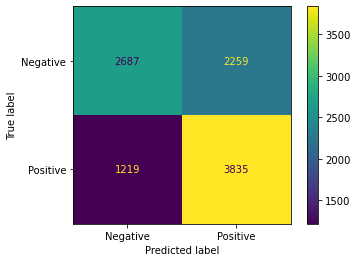

Accuracy : 0.6522
Balanced accuracy : 0.658611771107404
ROC AUC : 0.7150136391908752


In [15]:
conf_matrix(X, y, TfidfVectorizer(max_features = 1000, ngram_range=(2,2)), LogisticRegression())

# Comparaisons

C:\Users\pasqu\anaconda3\envs\data-2A\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\pasqu\anaconda3\envs\data-2A\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

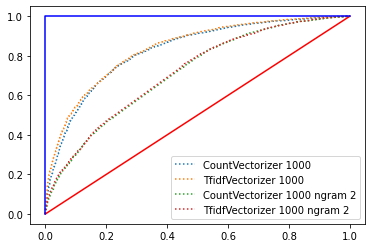

,accuracy,balanced_accuracy,roc_auc
CountVectorizer 1000,0.7526,0.753314,0.826828
TfidfVectorizer 1000,0.7565,0.756784,0.835926
CountVectorizer 1000 ngram 2,0.6471,0.654074,0.711632
TfidfVectorizer 1000 ngram 2,0.6522,0.658612,0.715014


In [16]:
table = []

N = 1000

_, _, _, y_test, probs, metrics_score = conf_matrix(X, y, CountVectorizer(max_features = N), LogisticRegression(), verbose=False)
fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
plt.plot(fpr,tpr,":", label=f"CountVectorizer {N}")
table.append(metrics_score)

_, _, _, y_test, probs, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features = N), LogisticRegression(), verbose=False)
fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
plt.plot(fpr,tpr,":", label=f"TfidfVectorizer {N}")
table.append(metrics_score)


_, _, _, y_test, probs, metrics_score = conf_matrix(X, y, CountVectorizer(max_features = N, ngram_range=(2,2)), LogisticRegression(), verbose=False)
fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
plt.plot(fpr,tpr,":", label=f"CountVectorizer {N} ngram 2")
table.append(metrics_score)


_, _, _, y_test, probs, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features = N, ngram_range=(2,2)), LogisticRegression(), verbose=False)
fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
plt.plot(fpr,tpr,":", label=f"TfidfVectorizer {N} ngram 2")
table.append(metrics_score)

plt.plot([0, 1], [0, 1], "r-")
plt.plot([0, 0, 1], [0, 1, 1], 'b-')

plt.legend()
plt.show()

pd.DataFrame(table, index=[f"CountVectorizer {N}", f"TfidfVectorizer {N}", f"CountVectorizer {N} ngram 2", f"TfidfVectorizer {N} ngram 2"])

**Conclusion :** Le modèle de feature extraction le plus performant est le `TfidfVectorizer`. L'ajout de la fonction ngram demande en fait d'augmenter le nombre de features (de $n$ à $n^2$, ce qui demande plus de temps de calcul.

C:\Users\pasqu\anaconda3\envs\data-2A\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\pasqu\anaconda3\envs\data-2A\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

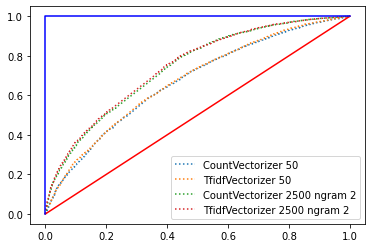

,accuracy,balanced_accuracy,roc_auc
CountVectorizer 50,0.6216,0.621558,0.668793
TfidfVectorizer 50,0.6230,0.622988,0.673267
CountVectorizer 2500 ngram 2,0.6729,0.677601,0.739642
TfidfVectorizer 2500 ngram 2,0.6779,0.681612,0.744797


In [17]:
table = []

N = 50

_, _, _, y_test, probs, metrics_score = conf_matrix(X, y, CountVectorizer(max_features = N), LogisticRegression(), verbose=False)
fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
plt.plot(fpr,tpr,":", label=f"CountVectorizer {N}")
table.append(metrics_score)

_, _, _, y_test, probs, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features = N), LogisticRegression(), verbose=False)
fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
plt.plot(fpr,tpr,":", label=f"TfidfVectorizer {N}")
table.append(metrics_score)


_, _, _, y_test, probs, metrics_score = conf_matrix(X, y, CountVectorizer(max_features = N**2, ngram_range=(2,2)), LogisticRegression(), verbose=False)
fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
plt.plot(fpr,tpr,":", label=f"CountVectorizer {N**2} ngram 2")
table.append(metrics_score)


_, _, _, y_test, probs, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features = N**2, ngram_range=(2,2)), LogisticRegression(), verbose=False)
fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
plt.plot(fpr,tpr,":", label=f"TfidfVectorizer {N**2} ngram 2")
table.append(metrics_score)

plt.plot([0, 1], [0, 1], "r-")
plt.plot([0, 0, 1], [0, 1, 1], 'b-')

plt.legend()
plt.show()

pd.DataFrame(table, index=[f"CountVectorizer {N}", f"TfidfVectorizer {N}", f"CountVectorizer {N**2} ngram 2", f"TfidfVectorizer {N**2} ngram 2"])

# Influence du nombre de features

array([  100.        ,   166.81005372,   278.25594022,   464.15888336,
         774.26368268,  1291.54966501,  2154.43469003,  3593.8136638 ,
        5994.84250319, 10000.        ])

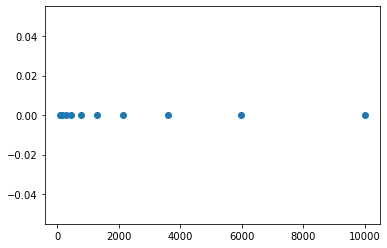

In [18]:
N = 10
plt.plot(np.logspace(2, 4, N, endpoint=True), np.zeros(N), 'o')
np.logspace(2, 4, N, endpoint=True)

In [19]:
%%time
N = 20
max_features_list = np.logspace(2, 3.8, N, endpoint=True, dtype=int)   # De 10^2 à 10^3.8
table = []
for max_features in max_features_list:
    _, _, _, _, _, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features = max_features), LogisticRegression(max_iter=200), verbose=False)
    table.append(metrics_score)
df = pd.DataFrame(table, index=max_features_list)

Wall time: 1min 20s


[]

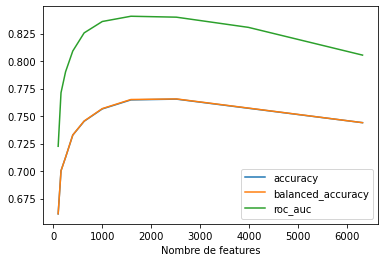

In [20]:
for i in df.columns:
    df[i].plot(label=i)

plt.legend()
plt.xlabel("Nombre de features")
plt.plot()